In [1]:

import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import temgymbasic.jax_components as comp
from temgymbasic.jax_utils import run_model_for_rays_and_slopes, find_input_slopes_that_hit_detpx_from_pt_source_with_semiconv
from temgymbasic.jax_run import run_model_for_jacobians
from temgymbasic.jax_ray import Ray
import os
import tqdm.auto as tqdm
from scipy.ndimage import rotate
from scipy.ndimage import zoom

import scipy

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".1"
%matplotlib widget
# jax.config.update("jax_platform_name", "cpu")

In [2]:
@jax.jit
def map_px_on_detector_to_scan(ScanGrid, Detector, detector_image,
                               ray_scan_coords_x, ray_scan_coords_y,
                               ray_det_coords_x, ray_det_coords_y):
    # When propgating backwards we need the negative of the scan rotation to be applied to the ray scan coordinates,
    # so that we can index pixels correctly on the scan grid - essentially we are rotating 
    # back into the coordinate system of the scan grid, so that a pixel at (0, 0) in the scan grid
    # represents the top left corner of the scan grid.
    
    scan_rotation = -ScanGrid.scan_rotation
    scan_step = ScanGrid.scan_step
    scan_shape = ScanGrid.scan_shape
    det_shape = Detector.shape
    det_pixel_size = Detector.pixel_size

    scan_rotation_rad = np.deg2rad(scan_rotation)
    ray_scan_coords_y_rot = np.cos(scan_rotation_rad) * ray_scan_coords_y - np.sin(scan_rotation_rad) * ray_scan_coords_x
    ray_scan_coords_x_rot = np.sin(scan_rotation_rad) * ray_scan_coords_y + np.cos(scan_rotation_rad) * ray_scan_coords_x

    # Convert rotated scan coordinates into pixel indices.
    scan_pixel_xs = jnp.round(ray_scan_coords_x_rot / scan_step[1] + scan_shape[1] / 2).astype(jnp.int32)
    scan_pixel_ys = jnp.round(ray_scan_coords_y_rot / scan_step[0] + scan_shape[0] / 2).astype(jnp.int32)

    # Create a mask of indices within bounds.
    mask = (scan_pixel_xs >= 0) & (scan_pixel_xs < scan_shape[1]) & \
           (scan_pixel_ys >= 0) & (scan_pixel_ys < scan_shape[0])
    
    det_pixel_xs = jnp.round(ray_det_coords_x / det_pixel_size + det_shape[1] / 2).astype(jnp.int32)
    det_pixel_ys = jnp.round(ray_det_coords_y / det_pixel_size + det_shape[0] / 2).astype(jnp.int32)

    detector_vals = detector_image[det_pixel_ys, det_pixel_xs]

    scan_pixel_xs = jnp.where(mask, scan_pixel_xs, 0)
    scan_pixel_ys = jnp.where(mask, scan_pixel_ys, 0)
    detector_vals = jnp.where(mask, detector_vals, 0)
    
    return scan_pixel_xs, scan_pixel_ys, detector_vals


@jax.jit
def map_px_on_scan_to_detector(Detector, sample_interpolant, 
                               ray_scan_coords_x, ray_scan_coords_y,
                               ray_det_coords_x, ray_det_coords_y):
    
    det_pixel_size = Detector.pixel_size
    det_shape = Detector.shape

    # Stack the scan coordinates.
    scan_pts = jnp.stack([ray_scan_coords_y, ray_scan_coords_x], axis=-1)
    sample_vals = sample_interpolant(scan_pts, )
    
    det_pixel_xs = jnp.round(ray_det_coords_x / det_pixel_size + det_shape[1] / 2).astype(jnp.int32)
    det_pixel_ys = jnp.round(ray_det_coords_y / det_pixel_size + det_shape[0] / 2).astype(jnp.int32)
    
    return det_pixel_xs, det_pixel_ys, sample_vals


In [3]:
@jax.jit
def get_transfer_matrices(model, scan_pos_m):

    # Unpack model components.
    PointSource = model[0]
    ScanGrid = model[1]
    Descanner = model[2]
    Detector = model[3]

    scan_y, scan_x = scan_pos_m[0], scan_pos_m[1]

    # Prepare input ray position for this scan point.
    input_ray_positions = jnp.array([scan_x, scan_y, 0.0, 0.0, 1.0])

    ray = Ray(
        z=PointSource.z,
        matrix=input_ray_positions,
        amplitude=jnp.ones(1),
        pathlength=jnp.zeros(1),
        wavelength=jnp.ones(1),
        blocked=jnp.zeros(1, dtype=float)
    )

    # Create a new Descanner with the current scan offsets.
    new_Descanner = comp.Descanner(
        z=ScanGrid.z,
        descan_error=Descanner.descan_error,
        offset_x=scan_x,
        offset_y=scan_y
    )

    current_model = [PointSource, ScanGrid, new_Descanner, Detector]

    transfer_matrices = run_model_for_jacobians(ray, current_model)

    total_transfer_matrix = transfer_matrices[-1]
    
    for tm in reversed(transfer_matrices[:-1]):
        total_transfer_matrix = total_transfer_matrix @ tm
    
    sample_to_detector = transfer_matrices[2] @ transfer_matrices[1]

    try:
        detector_to_sample = jnp.linalg.inv(sample_to_detector)
    except jnp.linalg.LinAlgError:
        print("Sample to Detector Matrix is singular, cannot invert. Returning identity matrix.")
        detector_to_sample = jnp.eye(5)

    return transfer_matrices, total_transfer_matrix, detector_to_sample

@jax.jit
def get_ray_coords_at_scan_and_det(model, scan_pos, total_transfer_matrix, transfer_matrices, detector_to_sample):
    
    PointSource = model[0]
    Detector = model[3]
    detector_coords_yx = Detector.coords
    semi_conv = PointSource.semi_conv 

    # Find all input slopes for a max semiconvergence angle that will hit the detector pixels
    input_slopes = find_input_slopes_that_hit_detpx_from_pt_source_with_semiconv(
        detector_coords_yx, scan_pos, semi_conv, total_transfer_matrix
    )
    
    # Run the model to obtain the ray coordinates at each component in the model
    coords = run_model_for_rays_and_slopes(transfer_matrices, input_slopes, scan_pos)

    # Stack coordinates and perform the inverse matrix multiplication to get the sample coordinates
    xs, ys, dxs, dys = coords
    detector_rays = jnp.stack([xs[-1], ys[-1], dxs[-1], dys[-1], jnp.ones_like(xs[-1])])
    sample_rays = jnp.dot(detector_to_sample, detector_rays)

    # Unpack the sample and detector ray coordinates
    sample_rays_x = sample_rays[0]
    sample_rays_y = sample_rays[1]
    det_rays_x = detector_rays[0]
    det_rays_y = detector_rays[1]

    return sample_rays_x, sample_rays_y, det_rays_x, det_rays_y


@jax.jit
def project_frame_forward(model, detector_frame, sample_interpolant, scan_pos):
    # Return all the transfer matrices necessary for us to use to propagate rays through the system
    transfer_matrices, total_transfer_matrix, detector_to_sample = get_transfer_matrices(model, scan_pos)

    # Get ray coordinates at the scan and detector
    sample_rays_x, sample_rays_y, det_rays_x, det_rays_y = get_ray_coords_at_scan_and_det(
        model, scan_pos, total_transfer_matrix, transfer_matrices, detector_to_sample
    )

    # Unpack model components.
    Detector = model[-1]

    # Map the detector pixel coordinates from scan grid to the detector
    det_x_px, det_y_px, sample_intensity = map_px_on_scan_to_detector(
        Detector, sample_interpolant, sample_rays_x, sample_rays_y, det_rays_x, det_rays_y
    )
    
    # Use JAX's index update to avoid in-place mutation
    detector_frame = detector_frame.at[det_y_px, det_x_px].set(sample_intensity)

    return detector_frame

@jax.jit
def project_frame_backward(model, detector_frame, scan_pos):
    # Return all the transfer matrices necessary for us to propagate rays through the system
    transfer_matrices, total_transfer_matrix, detector_to_sample = get_transfer_matrices(model, scan_pos)

    # Get ray coordinates at the scan and detector
    sample_rays_x, sample_rays_y, det_rays_x, det_rays_y = get_ray_coords_at_scan_and_det(
        model, scan_pos, total_transfer_matrix, transfer_matrices, detector_to_sample
    )

    # Map the detector pixel coordinates to the scan grid
    ScanGrid = model[1]
    Detector = model[-1]
    sample_x_px, sample_y_px, detector_intensity = map_px_on_detector_to_scan(
        ScanGrid, Detector, detector_frame, sample_rays_x, sample_rays_y, det_rays_x, det_rays_y
    )

    # Sum the detector intensity values at the scan pixel coordinates using JAX indexing updates
    shifted_sum = jnp.zeros(ScanGrid.scan_shape)
    shifted_sum = shifted_sum.at[sample_y_px, sample_x_px].add(detector_intensity)

    return shifted_sum

In [15]:
import scipy.interpolate

sample_image = plt.imread(r'SilverFast_Resolution_Target_USAF_1951.png')[:, :, 0]
image_shape = sample_image.shape

#remove the black pixel border on the edges
sample_image = sample_image[1:-1, 1:-1]

# Downsample the sample_image by a factor of 2
downsample_factor = 0.5
sample_image = zoom(sample_image, downsample_factor)
sample_image_shape = sample_image.shape

#This is something we can never access in the reverse model, 
# but we can use it to make rotation of an image on the detector possible in the forward model
sample_rotation = 64

sample_image = jnp.array(sample_image, dtype=np.complex64)
sample_px_size = 0.0001
sample_rotated = rotate(sample_image, sample_rotation, reshape=True, cval=1.0)
sample_rotated_edge_length_x = sample_rotated.shape[1] * sample_px_size
sample_rotated_edge_length_y = sample_rotated.shape[0] * sample_px_size

sample_coords_x = jnp.linspace(-sample_rotated_edge_length_x / 2, sample_rotated_edge_length_x / 2, sample_rotated.shape[1])
sample_coords_y = jnp.linspace(-sample_rotated_edge_length_y / 2, sample_rotated_edge_length_y / 2, sample_rotated.shape[0])

sample_interpolant = jax.scipy.interpolate.RegularGridInterpolator(
    (sample_coords_y, sample_coords_x), sample_rotated, fill_value=1.0, bounds_error=False, method='nearest'
)

Text(0.5, 1.0, 'Interpolated Sample Image')

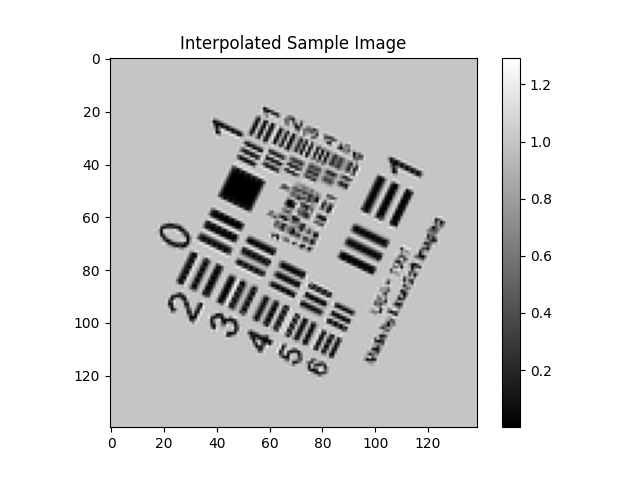

In [16]:
interpolant_image = sample_interpolant(jnp.stack(jnp.meshgrid(sample_coords_y, sample_coords_x, indexing='ij'), axis=-1))

plt.figure()
plt.imshow(jnp.abs(interpolant_image), cmap='gray')
plt.colorbar()
plt.title('Interpolated Sample Image')


In [32]:
# Linear Descan Error #1, 1, 0, 0 represents no descan pos or tilt error 
# Axx, Ayy, Cxx, Cyy = 4, 3, -5, -4 # Normal Descan Error terms Axx, Ayy, Cxx, Cyy in transfer matrix
# Axy, Ayx, Cxy, Cyx = 6, -7, -3, 5 # Cross Descan Error terms Axy, Ayx, Cxy, Cyx in transfer matrix
Axx, Ayy, Cxx, Cyy = 1, 1, 0, 0
Axy, Ayx, Cxy, Cyx = 0, 0, 0, 0

descan_error = [Axx, Axy, Ayx, Ayy, Cxx, Cxy, Cyx, Cyy]

#Set up the parameters for the simulation
defocus = 0.01
semi_conv = 0.05
camera_length = 1.0
scan_size = sample_image_shape
det_size = (64, 64)
scan_step_yx = (0.0001, 0.0001)
det_px_size= 0.002
scan_rotation = 0

params_dict = {
    'defocus': defocus,
    'semi_conv': semi_conv,
    'camera_length': camera_length,
    'scan_size': scan_size,
    'det_size': det_size,
    'scan_px_size': scan_step_yx,
    'det_px_size': det_px_size,
    'scan_rotation': scan_rotation,
    'descan_error': descan_error
}

#Create ray input z plane
crossover_z = jnp.zeros((1))

PointSource = comp.PointSource(z=crossover_z, semi_conv=semi_conv)
ScanGrid = comp.ScanGrid(z=jnp.array([params_dict['defocus']]), scan_step=params_dict['scan_px_size'], scan_shape=params_dict['scan_size'], scan_rotation=params_dict['scan_rotation'])
Descanner = comp.Descanner(z=jnp.array([params_dict['defocus']]), descan_error=params_dict['descan_error'], offset_x=0.0, offset_y=0.0)
Detector = comp.Detector(z=jnp.array([params_dict['camera_length']]), shape=det_size, pixel_size=params_dict['det_px_size'], rotation=0.0)
model = [PointSource, ScanGrid, Descanner, Detector]

Scan rotation and Sample rotation demonstration

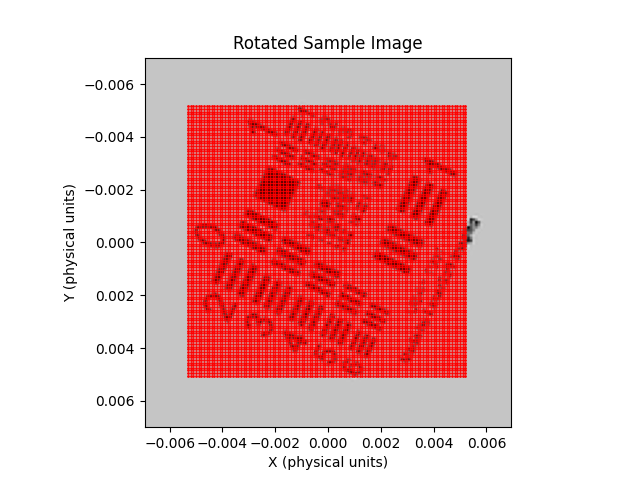

In [33]:
scan_coordinates = ScanGrid.get_coords()

# Set the physical extent (edges) centered around zero
extent = [
    -sample_rotated_edge_length_x/2,
    sample_rotated_edge_length_x/2,
    sample_rotated_edge_length_y/2,
    -sample_rotated_edge_length_y/2,
]

# Reshape the scan coordinates into a 2D grid (centers of pixels).
grid = scan_coordinates.reshape(ScanGrid.scan_shape[0], ScanGrid.scan_shape[1], 2)

plt.figure()
plt.imshow(np.abs(sample_rotated), cmap='gray', extent=extent)
plt.plot(grid[:, :, 1], grid[:, :, 0], 'ro', markersize=1)

plt.title('Rotated Sample Image')
plt.xlabel('X (physical units)')
plt.ylabel('Y (physical units)')
plt.show()

Generating the forward dataset:

In [34]:
fourdstem_array = jnp.zeros((*ScanGrid.scan_shape, *Detector.shape), dtype=jnp.complex64)

scan_coords_yx = ScanGrid.coords.reshape(*ScanGrid.scan_shape, 2)

@jax.jit
def compute_fourdstem_array_forward(model, scan_coords_yx):
    def _project_frame_forward(scan_pos):
        det_frame = jnp.zeros(Detector.shape, dtype=jnp.complex64)
        return project_frame_forward(model, det_frame, sample_interpolant, scan_pos)
    
    # Vectorize over both scan grid axes.
    vmapped_process = jax.vmap(jax.vmap(_project_frame_forward, in_axes=0), in_axes=0)
    return vmapped_process(scan_coords_yx)

fourdstem_array = compute_fourdstem_array_forward(model, scan_coords_yx).block_until_ready()


In [35]:
%timeit compute_fourdstem_array_forward(model, scan_coords_yx).block_until_ready()

42 ms ± 83.1 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


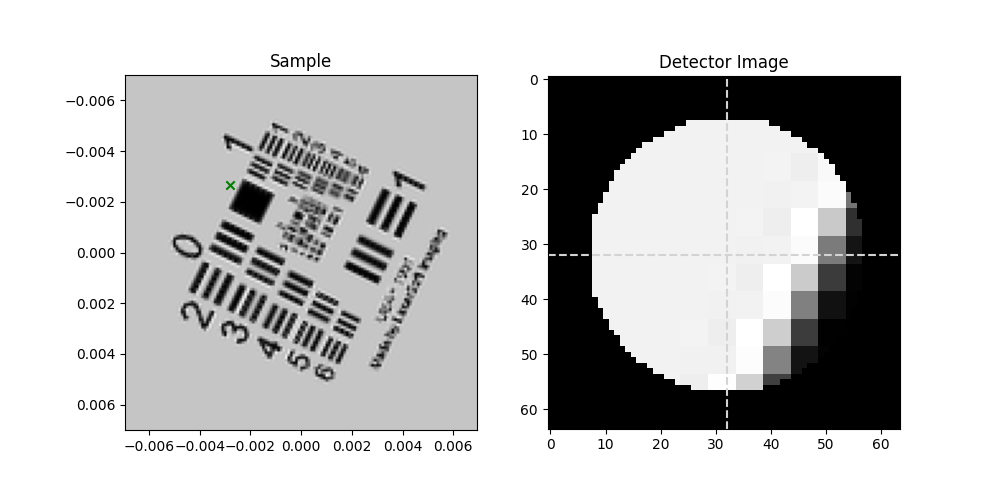

In [10]:
scan_idx_y, scan_idx_x = 25, 25
scan_pos_y, scan_pos_x = scan_coords_yx[scan_idx_y, scan_idx_x]
det_image_selected = fourdstem_array[scan_idx_y, scan_idx_x]
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(np.abs(sample_rotated), extent=extent, cmap='gray')
ax[0].scatter(scan_pos_x, scan_pos_y, c='g', marker='x', alpha=1)
ax[0].set_title('Sample')

ax[1].imshow(np.abs(det_image_selected), cmap='gray')
ax[1].axhline(Detector.shape[0]/2, color='lightgrey', linestyle='--')
ax[1].axvline(Detector.shape[1]/2, color='lightgrey', linestyle='--')
ax[1].set_title('Detector Image')
plt.show()

In [11]:
@jax.jit
def compute_shifted_sum(model, scan_coords_yx, fourdstem_array):
    def _project_frame_backward(scan_pos, det_frame):
        return project_frame_backward(model, det_frame, scan_pos)
    
    # Vectorize over both scan grid axes.
    vmapped_process = jax.vmap(jax.vmap(_project_frame_backward, in_axes=(0, 0)), in_axes=(0, 0))
    # Sum over all scan points to get the total shifted sum image.
    return vmapped_process(scan_coords_yx, fourdstem_array).sum(axis=(0, 1))

shifted_sum = compute_shifted_sum(model, scan_coords_yx, fourdstem_array).block_until_ready()

/nobackup/dl277493/.pyenv/versions/temgym/lib/python3.12/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=complex64 to dtype=float32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/nobackup/dl277493/.pyenv/versions/temgym/lib/python3.12/site-packages/jax/_src/ops/scatter.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return lax_internal._convert_element_type(out, dtype, weak_type)


In [12]:
%timeit shifted_sum = compute_shifted_sum(model, scan_coords_yx, fourdstem_array).block_until_ready()

591 ms ± 795 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Text(0.5, 1.0, 'Shifted Sum Image')

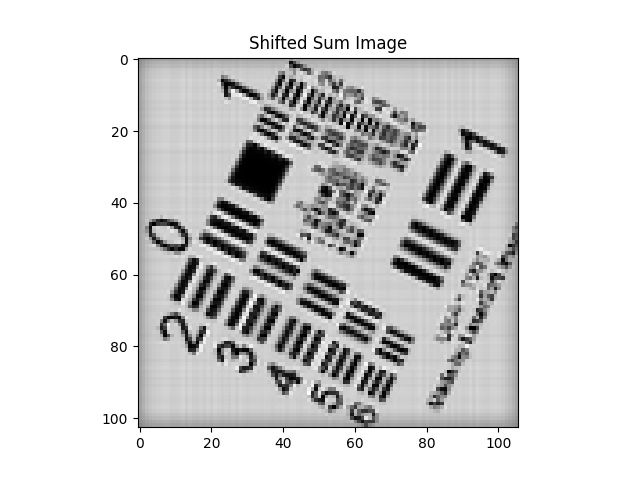

In [13]:
plt.figure()
plt.imshow(np.abs(shifted_sum), cmap='gray')
plt.title('Shifted Sum Image')

In [14]:
# %load_ext line_profiler
# %lprun -f project_frame -f map_px_on_detector_to_sample project_frame(model, frame, scan_idx, detector_coords_yx)

In [15]:
PointSource = comp.PointSource(z=crossover_z, semi_conv=semi_conv)
ScanGrid = comp.ScanGrid(z=jnp.array([params_dict['defocus']]), scan_step=params_dict['scan_px_size'], scan_shape=params_dict['scan_size'], scan_rotation=params_dict['scan_rotation'])
Descanner = comp.Descanner(z=jnp.array([params_dict['defocus']]), descan_error=params_dict['descan_error'], offset_x=0.0, offset_y=0.0)
Detector = comp.Detector(z=jnp.array([params_dict['camera_length']]), shape=det_size, pixel_size=params_dict['det_px_size'], rotation=0.0)
model = [PointSource, ScanGrid, Descanner, Detector]

input_ray_positions = jnp.array([[0.0, 0.0, 0.0, 0.0, 1.0]])

ray = Ray(
    z=jnp.array([0.0]),
    matrix=input_ray_positions,
    amplitude=jnp.ones(1),
    pathlength=jnp.zeros(1),
    wavelength=jnp.ones(1),
    blocked=jnp.zeros(1, dtype=float)
)

In [16]:
import panel as pn
pn.extension()

In [18]:
from libertem_ui.live_plot import ApertureFigure
from bokeh.models.formatters import PrintfTickFormatter

shifted_sum_array = np.random.uniform(size=det_size)

def run_model_inner(params_dict):
    defocus = params_dict['defocus']
    semi_conv = params_dict['semi_conv']
    camera_length = params_dict['camera_length']
    det_size = params_dict['det_size']
    scan_size = params_dict['scan_size']
    scan_px_size = params_dict['scan_px_size']
    det_px_size = params_dict['det_px_size']
    scan_rotation = params_dict['rotation']
    descan_error = params_dict['descan_error']

    
    PointSource = comp.PointSource(z=crossover_z, 
                                   semi_conv=semi_conv)
    ScanGrid = comp.ScanGrid(z=defocus, 
                             scan_step=scan_px_size, 
                             scan_shape=scan_size, 
                             scan_rotation=scan_rotation)
    Descanner = comp.Descanner(z=defocus, 
                               descan_error=descan_error, 
                               offset_x=0.0, offset_y=0.0)
    Detector = comp.Detector(z=camera_length, 
                             shape=det_size, 
                             pixel_size=det_px_size, 
                             rotation=0.0)
    
    model = [PointSource, ScanGrid, Descanner, Detector]


    shifted_sum_image = compute_shifted_sum(model, scan_coords_yx, fourdstem_array)

    return np.abs(shifted_sum_image)


defocus_slider = pn.widgets.FloatSlider(name="defocus", value=0.001, start=0.001, end=0.1, step=0.001, format=PrintfTickFormatter(format='%.3f m'))
semi_conv_slider = pn.widgets.FloatSlider(name="semi_conv", value=0.01, start=0.01, end=0.1, step=0.001, format=PrintfTickFormatter(format='%.3f slope'))
camera_length_slider = pn.widgets.FloatSlider(name="camera_length", value=1.0, start=0.1, end=10, format=PrintfTickFormatter(format='%.3f m'))
scan_px_size_slider = pn.widgets.FloatSlider(name="scan_px_size", value=0.0001, start=0.0001, end=0.01, step=0.0001, format=PrintfTickFormatter(format='%.4f m'))
det_px_size_slider = pn.widgets.FloatSlider(name="det_px_size", value=.002, start=0.0001, end=0.01, step=0.0001, format=PrintfTickFormatter(format='%.4f m'))
rotation_slider = pn.widgets.FloatSlider(name="rotation", start=0., end=360, step=0.01, value=0.02, format=PrintfTickFormatter(format='%.3f degrees'))

Axx_slider = pn.widgets.FloatSlider(name="Axx", value=4, start=-10, end=10, step=0.1)
Axy_slider = pn.widgets.FloatSlider(name="Axy", value=6, start=-10, end=10, step=0.1)
Ayx_slider = pn.widgets.FloatSlider(name="Ayx", value=-7, start=-10, end=10, step=0.1)
Ayy_slider = pn.widgets.FloatSlider(name="Ayy", value=3, start=-10, end=10, step=0.1)
Cxx_slider = pn.widgets.FloatSlider(name="Cxx", value=-5, start=-10, end=10, step=0.1)
Cxy_slider = pn.widgets.FloatSlider(name="Cxy", value=-3, start=-10, end=10, step=0.1)
Cyx_slider = pn.widgets.FloatSlider(name="Cyx", value=5, start=-10, end=10, step=0.1)
Cyy_slider = pn.widgets.FloatSlider(name="Cyy", value=-4, start=-10, end=10, step=0.1)

figure = (
    ApertureFigure
    .new(shifted_sum_array, tools=False, maxdim=600)
)


def run_model(*e):
    defocus_v = defocus_slider.value
    semi_conv_v = semi_conv_slider.value
    camera_length_v = camera_length_slider.value
    scan_px_size_v = (scan_px_size_slider.value, scan_px_size_slider.value)
    det_px_size_v = det_px_size_slider.value
    rotation_v = rotation_slider.value

    descan_error_v = [Axx_slider.value, Axy_slider.value, Ayx_slider.value, Ayy_slider.value, 
                      Cxx_slider.value, Cxy_slider.value, Cyx_slider.value, Cyy_slider.value]

    params_dict = {
        'defocus': defocus_v,
        'semi_conv': semi_conv_v,
        'camera_length': camera_length_v,
        'scan_size': sample_image_shape,
        'det_size': det_size,
        'scan_px_size': scan_px_size_v,
        'det_px_size': det_px_size_v,
        'rotation': rotation_v,
        'descan_error': descan_error_v}

    image = run_model_inner(params_dict)
    figure.im.update(image)


defocus_slider.param.watch(run_model, 'value_throttled')
semi_conv_slider.param.watch(run_model, 'value_throttled')
camera_length_slider.param.watch(run_model, 'value_throttled')
scan_px_size_slider.param.watch(run_model, 'value_throttled')
det_px_size_slider.param.watch(run_model, 'value_throttled')
rotation_slider.param.watch(run_model, 'value_throttled')
Axx_slider.param.watch(run_model, 'value_throttled')
Axy_slider.param.watch(run_model, 'value_throttled')
Ayx_slider.param.watch(run_model, 'value_throttled')
Ayy_slider.param.watch(run_model, 'value_throttled')
Cxx_slider.param.watch(run_model, 'value_throttled')
Cxy_slider.param.watch(run_model, 'value_throttled')
Cyx_slider.param.watch(run_model, 'value_throttled')
Cyy_slider.param.watch(run_model, 'value_throttled')

pn.Row(
    pn.Column(
        defocus_slider,
        semi_conv_slider,
        camera_length_slider,
        scan_px_size_slider,
        det_px_size_slider,
        rotation_slider,
        pn.Row(
            pn.Column(
                Axx_slider,
                Axy_slider,
                Ayx_slider,
                Ayy_slider
            ),
            pn.Column(
                Cxx_slider,
                Cxy_slider,
                Cyx_slider,
                Cyy_slider
            )
        )
    ),
    figure.layout
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'c7414889-a4d2-4579-8a4a-113cecd82071': {'version…